<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision.models as md
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [42]:
! gdown --id 1DOqI__TyW4qvpRqAHOmVCm9LjXRHHBZY

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1DOqI__TyW4qvpRqAHOmVCm9LjXRHHBZY
From (redirected): https://drive.google.com/uc?id=1DOqI__TyW4qvpRqAHOmVCm9LjXRHHBZY&confirm=t&uuid=2ff15a0d-7808-4c5e-a2b9-3ceb62be1eb2
To: /content/DataSet.zip
100% 4.28G/4.28G [01:06<00:00, 64.7MB/s]


In [44]:
!unzip -q DataSet.zip -d dataset

In [45]:
def get_dataloader(image_size):
    path='dataset/DataSet'
    transform = tt.Compose([tt.Resize(image_size),
                            tt.CenterCrop(image_size),
                            tt.ToTensor()])
    x = ImageFolder(path,transform)
    lst=[]
    for i in x:
        lst.append(i)

    return lst

In [46]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [47]:
image_size = 128
batch_size = 32
train_dataset = get_dataloader(image_size)

In [48]:
train_dataloader = DeviceDataLoader(DataLoader(train_dataset, batch_size,
                                    shuffle=False, num_workers=2, pin_memory=True),device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [49]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [50]:
latent_size = 160

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [51]:
lr = 0.0002

model = {
    "discriminator": to_device(discriminator, device),
    "generator": to_device(generator, device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [52]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dataloader):
            #Обучаем дискриминатор
            optimizer["discriminator"].zero_grad()

            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            #обучаем генератор
            optimizer["generator"].zero_grad()

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

    return losses_g, losses_d, real_scores, fake_scores

In [53]:
history = fit(model, criterion, 60, lr)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 15.7254, loss_d: 0.5375, real_score: 0.9432, fake_score: 0.1189


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 10.6999, loss_d: 0.5570, real_score: 0.9036, fake_score: 0.1001


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 10.3840, loss_d: 0.2883, real_score: 0.9310, fake_score: 0.0708


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 9.3315, loss_d: 0.0220, real_score: 0.9902, fake_score: 0.0111


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 9.9142, loss_d: 0.0084, real_score: 0.9965, fake_score: 0.0035


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 7.8075, loss_d: 0.0060, real_score: 0.9971, fake_score: 0.0030


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 7.9942, loss_d: 0.1746, real_score: 0.9795, fake_score: 0.0074


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 8.5037, loss_d: 0.3224, real_score: 0.9315, fake_score: 0.0693


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 7.7245, loss_d: 0.1683, real_score: 0.9570, fake_score: 0.0483


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 8.5322, loss_d: 0.0400, real_score: 0.9843, fake_score: 0.0201


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 12.5741, loss_d: 0.0101, real_score: 0.9951, fake_score: 0.0043


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 8.1645, loss_d: 0.0084, real_score: 0.9970, fake_score: 0.0051


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 12.3936, loss_d: 0.0010, real_score: 0.9991, fake_score: 0.0001


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 22.9703, loss_d: 0.1108, real_score: 0.9763, fake_score: 0.0155


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 12.5588, loss_d: 0.3003, real_score: 0.9665, fake_score: 0.0373


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 5.2409, loss_d: 0.6568, real_score: 0.8325, fake_score: 0.1522


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 3.2431, loss_d: 0.9311, real_score: 0.7198, fake_score: 0.2767


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 3.5502, loss_d: 0.9369, real_score: 0.7511, fake_score: 0.2525


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 3.8244, loss_d: 0.7731, real_score: 0.7681, fake_score: 0.2307


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 4.1104, loss_d: 0.7559, real_score: 0.7722, fake_score: 0.2287


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 4.4037, loss_d: 0.7291, real_score: 0.7873, fake_score: 0.2150


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 4.0929, loss_d: 0.8038, real_score: 0.7608, fake_score: 0.2312


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 4.3862, loss_d: 0.7274, real_score: 0.7823, fake_score: 0.2181


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 4.4737, loss_d: 0.7107, real_score: 0.7834, fake_score: 0.2135


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 4.2276, loss_d: 0.7186, real_score: 0.7761, fake_score: 0.2148


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 4.5081, loss_d: 0.7355, real_score: 0.7874, fake_score: 0.2135


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 4.6397, loss_d: 0.6362, real_score: 0.8026, fake_score: 0.1903


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 4.5107, loss_d: 0.6363, real_score: 0.8055, fake_score: 0.1915


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 4.4923, loss_d: 0.6420, real_score: 0.8009, fake_score: 0.1960


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 4.5394, loss_d: 0.6217, real_score: 0.8110, fake_score: 0.1847


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 4.8471, loss_d: 0.5488, real_score: 0.8247, fake_score: 0.1743


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 4.8628, loss_d: 0.6381, real_score: 0.8100, fake_score: 0.1832


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 4.9382, loss_d: 0.5397, real_score: 0.8252, fake_score: 0.1735


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 5.0692, loss_d: 0.5522, real_score: 0.8267, fake_score: 0.1698


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 5.0347, loss_d: 0.5258, real_score: 0.8388, fake_score: 0.1614


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 4.9371, loss_d: 0.4228, real_score: 0.8569, fake_score: 0.1395


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 5.4069, loss_d: 0.5295, real_score: 0.8406, fake_score: 0.1568


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 5.2826, loss_d: 0.4516, real_score: 0.8500, fake_score: 0.1465


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 5.4314, loss_d: 0.4776, real_score: 0.8505, fake_score: 0.1515


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 5.5002, loss_d: 0.5472, real_score: 0.8368, fake_score: 0.1557


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 5.2663, loss_d: 0.4146, real_score: 0.8676, fake_score: 0.1338


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 5.3753, loss_d: 0.3751, real_score: 0.8756, fake_score: 0.1207


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 5.5414, loss_d: 0.4720, real_score: 0.8546, fake_score: 0.1432


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 5.6599, loss_d: 0.4409, real_score: 0.8607, fake_score: 0.1366


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 5.5715, loss_d: 0.4058, real_score: 0.8754, fake_score: 0.1238


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 5.4187, loss_d: 0.3813, real_score: 0.8767, fake_score: 0.1214


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 6.1725, loss_d: 0.3696, real_score: 0.8871, fake_score: 0.1154


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 5.8078, loss_d: 0.4228, real_score: 0.8671, fake_score: 0.1278


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 5.9880, loss_d: 0.4948, real_score: 0.8611, fake_score: 0.1381


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 5.4303, loss_d: 0.3339, real_score: 0.8849, fake_score: 0.1124


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 6.0406, loss_d: 0.4097, real_score: 0.8794, fake_score: 0.1184


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 5.8560, loss_d: 0.2510, real_score: 0.9101, fake_score: 0.0896


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 6.1534, loss_d: 0.4585, real_score: 0.8677, fake_score: 0.1305


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 5.5918, loss_d: 0.3199, real_score: 0.8936, fake_score: 0.1040


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 6.0075, loss_d: 0.3959, real_score: 0.8872, fake_score: 0.1125


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 5.6587, loss_d: 0.2204, real_score: 0.9147, fake_score: 0.0833


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 6.8846, loss_d: 0.4195, real_score: 0.8779, fake_score: 0.1240


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 5.8897, loss_d: 0.3683, real_score: 0.8946, fake_score: 0.1052


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 5.6382, loss_d: 0.3478, real_score: 0.9004, fake_score: 0.0973


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 6.0306, loss_d: 0.2913, real_score: 0.9010, fake_score: 0.0974


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [54]:
loss_gen=history[0]
loss_disc=history[1]

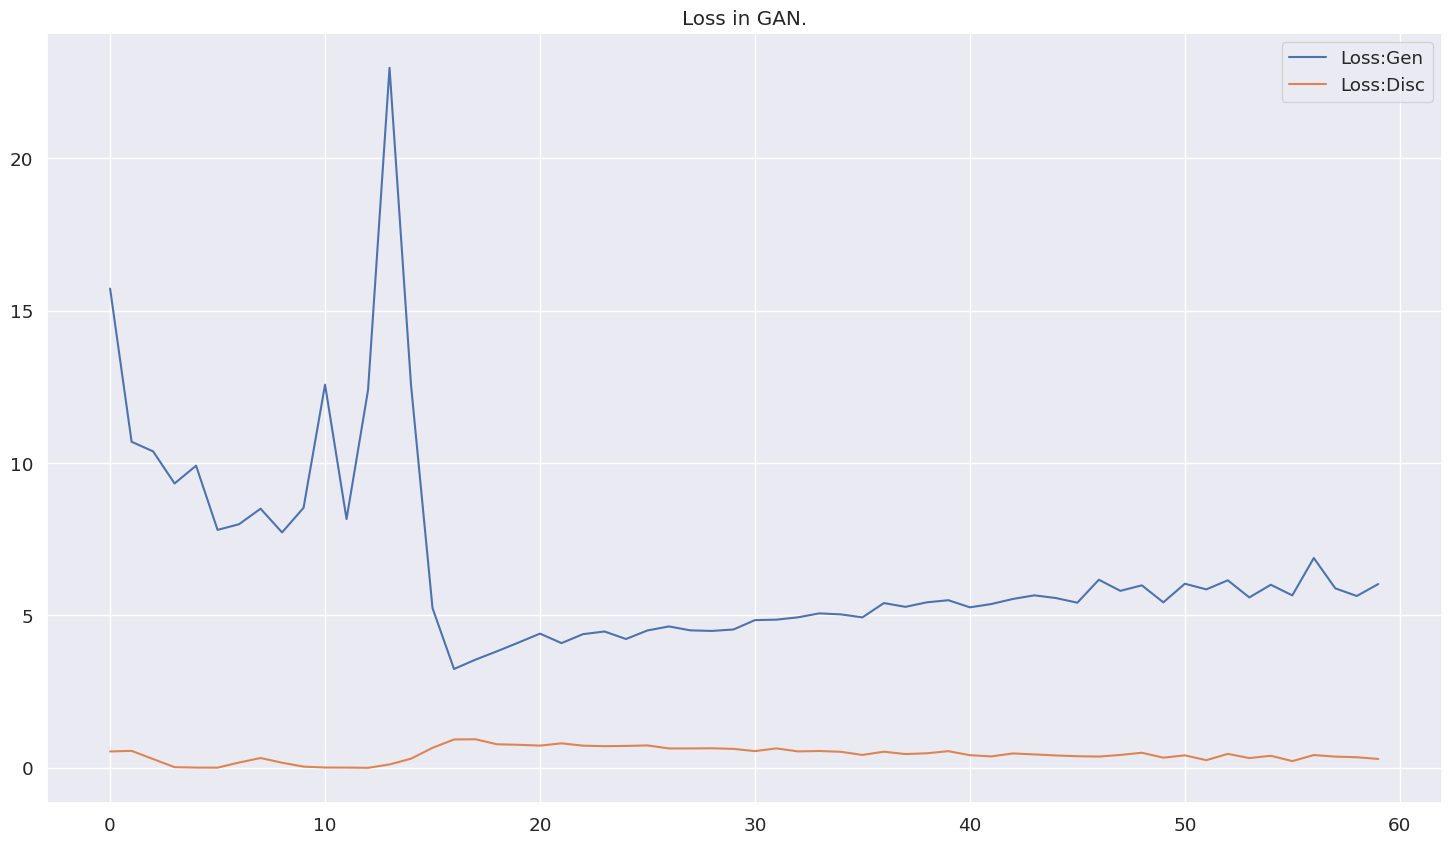

In [55]:
plt.figure(figsize=(18,10))
plt.plot([float(i) for i in loss_gen],label='Loss:Gen')
plt.plot([float(i) for i in loss_disc],label='Loss:Disc')
plt.title("Loss in GAN.")
plt.legend()

Лосс дискриминатора стабильно уменьшается, а лосс генератора - увеличивается. Вероятно, что дискриминатор более сильная модель, чем генератор.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [57]:
def show_images(images, nmax=128):
    # TODO: show generated images
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax].to('cpu'), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=128):
    for images in dl:
        show_images(images, nmax)

In [58]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model['generator'](fixed_latent).to('cpu')

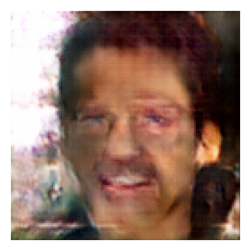

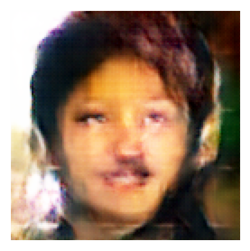

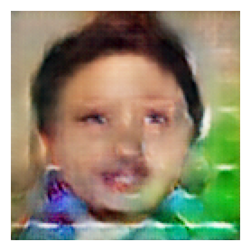

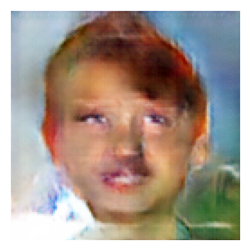

In [59]:
show_batch(fake_images)

**Как вам качество получившихся изображений?**

Когда фоткаюсь на документы, у меня примерно такие же фотки получаются.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [60]:
modelFeatch=md.resnet18(pretrained=True)
modelFeatch.fc=nn.Identity()
modelFeatch.layer4=nn.Identity()
modelFeatch.layer3=nn.Identity()
modelFeatch=modelFeatch.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 45.3MB/s]


In [61]:
n_images=3100
train_dataloader = train_dataset[0:n_images]

In [62]:
train_dataloader_data = DeviceDataLoader(DataLoader(train_dataloader, 100,
                                               shuffle=False, num_workers=2, pin_memory=True),torch.device('cuda'))

In [63]:
lst=[]
i=0
with torch.no_grad():
    for x,y in train_dataloader_data:
        torch.cuda.empty_cache()
        lst+=list(zip(modelFeatch(x).to('cpu'),[1]*n_images))

In [64]:
with torch.no_grad():
    for i in range(31):
        x=model["generator"](torch.randn(100, latent_size, 1, 1, device=device))
        lst+=list(zip(modelFeatch(x).to('cpu'),[0]*n_images))

In [65]:
x,y=next(iter(DeviceDataLoader(DataLoader(lst, 6200,
                                               shuffle=False, num_workers=2, pin_memory=True),torch.device('cpu'))))

In [66]:
Loo=LeaveOneOut()
indexes=[int(i) for i in range(n_images*2)]
ch=0

for ind_train,ind_test in Loo.split(indexes):
    modelONN=KNeighborsClassifier(n_neighbors=1)
    modelONN.fit(x[ind_train],y[ind_train])
    pred=modelONN.predict(x[ind_test])
    if pred[0]==y[ind_test]:
        ch+=1
print(ch/(n_images*2))

0.770483870967742


**Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?**

Модель с высокой точностью определяет принадлежность объектов к классам, что свидетельствует о том, что объекты не похожи. Результат плохой.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

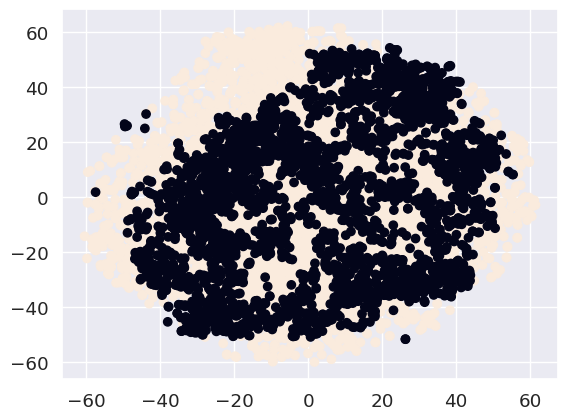

In [67]:
Emb = TSNE(n_components=2).fit_transform(x,y)
x1=Emb[:,0]
y1=Emb[:,1]
plt.scatter(x1,y1,c=y)

**Прокомментируйте получившийся результат:**

Изображения не очень похожи (точки разделяются) - модель плохо воспроизводит изображения лиц людей.